# Import Dependencies

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
#keras version
import keras
print(keras.__version__)
from keras.models import Sequential 
import tensorflow as tf

from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import pickle 
from datetime import datetime

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from math import dist
import numpy as np
from geopy.distance import geodesic
from haversine import haversine

/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.15.0


In [2]:





def haversine_dist(x1,x2,y1,y2):
   return haversine((x1, x2) , (y1, y2), unit='km')

# Data Processing 



def extract_features_from_longitude_latitude(df_old, home_longitude, home_latitude):
        df = df_old.copy()        
        df = df.dropna(subset=["mean_latitude", "mean_longitude"])

        df.loc[:,"distance_from_home"] = np.vectorize(haversine_dist)(
            df["mean_latitude"],
            df["mean_longitude"],
            home_latitude,
            home_longitude,
        )

        df.loc[:,"heading_to_home"] = np.arctan2(
            df["mean_latitude"] - home_latitude,
            df["mean_longitude"] - home_longitude,
        )
        df.loc[:,"heading_to_home_sin"] = np.sin(df["heading_to_home"])
        df.loc[:,"heading_to_home_cos"] = np.cos(df["heading_to_home"])
        # resample by 10m mean
        df.loc[:,"time_stamp"] = df.index
        # calculate the speed of device
        df.loc[:,"time_diff"] = (
            df["time_stamp"].diff().dt.total_seconds() / 3600
        )  # Convert seconds to hours
        df.loc[:,"distance"] = np.vectorize(haversine_dist)(
            df["mean_latitude"],
            df["mean_longitude"],
            df["mean_latitude"].shift(1),
            df["mean_longitude"].shift(1),
        )  # calculate haversine distance
        # df['hours'] = (df['time_stamp'].astype(int) / 10**9) / 60*60 # convert to seconds
        # df['time_taken'] = df['hours'] - df['hours'].shift(1) # calculate time difference

        df.loc[:,"speed"] = df["distance"] / df["time_diff"]  # cal speed
        df.loc[ df["speed"] > 200, "speed"] = 0
        df.loc[:,"speed_towards_home"] = df["speed"] * df["heading_to_home_cos"]
        return df

# df = df.resample('10T').mean()


In [3]:
from influxdb import DataFrameClient
import pandas as pd
db_name_zuka = 'smart_home_zukalovi'
dataframe_client_zuka = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_zukalovi',
        )

left_time_interval = pd.to_datetime('2023-10-01 00:00:00')
right_time_interval = pd.to_datetime('2024-04-22 15:00:00')
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = '10s'
tmp_output_water_entity_id_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant_2'
tmp_boiler_case_entity_id_zuka = 'esphome_web_c771e8_tmp3'
relay_entity_id_zuka = 'shelly1pm_84cca8b07eae'
device_tracker_entity_zuka = 'klara_z_iphone'


In [4]:
dataframe_client_form = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_formankovi',
        )
db_name_form = 'smart_home_formankovi'
tmp_output_water_entity_id_form = 'esphome_boiler_temps_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_form = 'esphome_web_b7a7f1_ntc_temperature_b_constant'
tmp_boiler_case_entity_id_form = 'shelly1pm_34945475a969_temperature_2'
relay_entity_id_form = 'shelly1pm_34945475a969'
device_tracker_entity_form = 'rmx3085'

In [5]:

# format datetime to YYYY-MM-DDTHH:MM:SSZ


def get_queries(db_name, left_time_interval, right_time_interval, group_by_time_interval, tmp_output_water_entity_id, tmp_output_water_entity_id_2, tmp_boiler_case_entity_id, relay_entity_id, device_tracker_entity):

    return {
        "water_flow": {
            "sql_query": f'SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "{db_name}"."autogen"."L/min" WHERE time > {left_time_interval} AND time < {right_time_interval} GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "L/min",
        },
        "water_temperature": {
            "sql_query": f'SELECT mean("value") AS "water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND ("entity_id"=\'{tmp_output_water_entity_id}\' OR "entity_id"=\'{tmp_output_water_entity_id_2}\') GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "°C",
        },
        "temperature": {
            "sql_query": f'SELECT mean("temperature") AS "outside_temperature_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "humidity": {
            "sql_query": f'SELECT mean("humidity") AS "outside_humidity_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "wind_speed": {
            "sql_query": f'SELECT mean("wind_speed") AS "outside_wind_speed_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "presence": {
            "sql_query": f'SELECT count(distinct("friendly_name_str")) AS "device_presence_distinct_count" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "state"=\'home\' GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "state",
        },
        "boiler_water_temperature": {
            "sql_query": f'SELECT mean("value") AS "boiler_water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{tmp_boiler_case_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "°C",
        },
        "boiler_relay_status": {
            "sql_query": f'SELECT last("value") AS "boiler_relay_status" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{relay_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "device_longitude": {
            "sql_query": f'SELECT mean("longitude") AS "mean_longitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(previous)',
            "measurement": "state",
        },
        "device_latitude": {
            "sql_query": f'SELECT mean("latitude") AS "mean_latitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(previous)',
            "measurement": "state",
        },
        
    } 

In [6]:
# df_all_list = []

# for key, value in get_queries(db_name = db_name_form, left_time_interval = left_time_interval, right_time_interval = right_time_interval, group_by_time_interval = group_by_time_interval, tmp_output_water_entity_id = tmp_output_water_entity_id_form, tmp_output_water_entity_id_2 = tmp_output_water_entity_id_2_form, tmp_boiler_case_entity_id = tmp_boiler_case_entity_id_form, relay_entity_id = relay_entity_id_form, device_tracker_entity = device_tracker_entity_form).items():
#     print("Querying: ", key, value["sql_query"])
#     # get data from influxdb
#     result = dataframe_client_form.query(value["sql_query"])[
#         value["measurement"]
#     ]

#     df = pd.DataFrame(result)
    
#     df_all_list.append(df)

# df_concat_form = pd.concat(df_all_list, axis=1)
# # save as pkl
# with open('df_form_mult_22042024.pkl', 'wb') as f:
#     df_concat_form.to_pickle(f)

In [7]:
# df_all_list = []
#     # iterate over key an value in data
# for key, value in get_queries(db_name=db_name_zuka, left_time_interval=left_time_interval, right_time_interval=right_time_interval, group_by_time_interval='10s', tmp_output_water_entity_id=tmp_output_water_entity_id_2_zuka, tmp_output_water_entity_id_2=tmp_output_water_entity_id_zuka, tmp_boiler_case_entity_id=tmp_boiler_case_entity_id_zuka, relay_entity_id=relay_entity_id_zuka, device_tracker_entity=device_tracker_entity_zuka).items():
#     print("Querying: ", key, value["sql_query"])
#     # get data from influxdb
#     result = dataframe_client_zuka.query(value["sql_query"])[
#         value["measurement"]
#     ]

#     df = pd.DataFrame(result)
    
#     df_all_list.append(df)

# df_concat_zuka = pd.concat(df_all_list, axis=1)
# # save as pkl
# with open('df_zuka_mult_22042024.pkl', 'wb') as f:
#     df_concat_zuka.to_pickle(f)

In [8]:
#load df form pkl
with open('df_form_mult_22042024.pkl', 'rb') as f:
    df_concat_form = pickle.load(f)
    df_concat_form = df_concat_form.dropna(subset=['water_temperature_mean'])

    
    


In [9]:
with open('df_zuka_mult_22042024.pkl', 'rb') as f:
    df_concat_zuka = pickle.load(f)
    df_concat_zuka = df_concat_zuka.dropna(subset=['water_temperature_mean'])
    


In [10]:
#49.412897925874184, 16.514843458109933
zuka_home_longitude = 16.514843458109933
zuka_home_latitude = 49.412897925874184
df_copy_zuka = df_concat_zuka.copy()
df_extracted_zuka = extract_features_from_longitude_latitude(df_copy_zuka, home_longitude=zuka_home_longitude, home_latitude=zuka_home_latitude)
# all value in speed larger than 200 set to 0
df_extracted_zuka.loc[df_extracted_zuka['speed'] > 200, 'speed'] = 0

In [11]:

    

# 49.39534649920643, 16.527887919743097
form_home_longitude = 16.527887919743097
form_home_latitude = 49.39534649920643

df_copy_form = df_concat_form.copy()
df_extracted_form = extract_features_from_longitude_latitude(df_copy_form, home_longitude=form_home_longitude, home_latitude=form_home_latitude)
# all value in speed larger than 200 set to 0
df_extracted_form.loc[df_extracted_form['speed'] > 200, 'speed'] = 0

In [12]:
from data_handler import DataHandler

Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/data_handler.py


In [13]:
left_time_interval = pd.to_datetime("2023-10-01 00:00:00")
right_time_interval = pd.to_datetime("2024-3-16 15:00:00")
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = "10s"
tmp_output_water_entity_id_zuka = "esphome_web_c771e8_ntc_temperature_b_constant"
tmp_output_water_entity_id_2_zuka = "esphome_web_c771e8_ntc_temperature_b_constant_2"
tmp_boiler_case_entity_id_zuka = "esphome_web_c771e8_tmp3"
relay_entity_id_zuka = "shelly1pm_84cca8b07eae"
relay_power_entity_id_zuka = "shelly1pm_84cca8b07eae_power"
device_tracker_entity_zuka = "klara_z_iphone"
device_tracker_entity_zuka_2 = "anezka_iphone"


dataHandlerZuka = DataHandler(
    "localhost", "smart_home_zukalovi", "root", "root", relay_entity_id_zuka, relay_power_entity_id_zuka, tmp_boiler_case_entity_id_zuka, tmp_output_water_entity_id_zuka, tmp_output_water_entity_id_2_zuka, device_tracker_entity_zuka,device_tracker_entity_zuka_2, zuka_home_longitude, zuka_home_latitude
)

In [14]:
db_name_form = 'smart_home_formankovi'
tmp_output_water_entity_id_form = 'esphome_boiler_temps_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_form = 'esphome_web_b7a7f1_ntc_temperature_b_constant'
tmp_boiler_case_entity_id_form = 'shelly1pm_34945475a969_temperature_2'
relay_entity_id_form = 'shelly1pm_34945475a969'
relay_power_entity_id_form = 'shelly1pm_34945475a969_power'
device_tracker_entity_form = 'rmx3085'
device_tracker_entity_form_2 = 'rmx3085'

dataHandlerForm = DataHandler(
    "localhost", db_name_form, "root", "root", relay_entity_id_form, relay_power_entity_id_form, tmp_boiler_case_entity_id_form, tmp_output_water_entity_id_form, tmp_output_water_entity_id_2_form, device_tracker_entity_form, device_tracker_entity_form_2, form_home_longitude, form_home_latitude
)

In [15]:

# data_processed_zuka = dataHandlerZuka.process_kWh_water_consumption(df_extracted_zuka)
# data_processed_zuka_ml = dataHandlerZuka.transform_data_for_ml(data_processed_zuka)
# ml_data_zuka = data_processed_zuka_ml[0]

ml_data_zuka, datetimes_zuka = dataHandlerZuka.get_data_for_prediction(datetime(2023, 10, 1, 0, 0, 0), datetime(2024, 4, 22, 0, 0, 0))

In [16]:
# data_processed_form = dataHandlerForm.process_kWh_water_consumption(df_extracted_form)
# data_processed_form_ml = dataHandlerForm.transform_data_for_ml(data_processed_form)
# ml_data_form = data_processed_form_ml[0]

ml_data_form, datetimes_form = dataHandlerForm.get_data_for_prediction(datetime(2023, 10, 1, 0, 0, 0), datetime(2024, 4, 22, 0, 0, 0))


In [17]:
ml_data_form_datetimes = ml_data_form.copy()
ml_data_form_datetimes.index = datetimes_form

ml_data_zuka_datetimes = ml_data_zuka.copy()
ml_data_zuka_datetimes.index = datetimes_zuka



# replace nan humidity, temeprature and wind_speed with values with same index from ml_data_zuka
ml_data_form_datetimes['temperature'] = ml_data_form_datetimes['temperature'].combine_first(ml_data_zuka_datetimes['temperature'])
ml_data_form_datetimes['humidity'] = ml_data_form_datetimes['humidity'].combine_first(ml_data_zuka_datetimes['humidity'])
ml_data_form_datetimes['wind_speed'] = ml_data_form_datetimes['wind_speed'].combine_first(ml_data_zuka_datetimes['wind_speed'])

# ffill this values
ml_data_form_datetimes['temperature'] = ml_data_form_datetimes['temperature'].ffill()
ml_data_form_datetimes['humidity'] = ml_data_form_datetimes['humidity'].ffill()
ml_data_form_datetimes['wind_speed'] = ml_data_form_datetimes['wind_speed'].ffill()
ml_data_form = ml_data_form_datetimes.reset_index(drop=True)



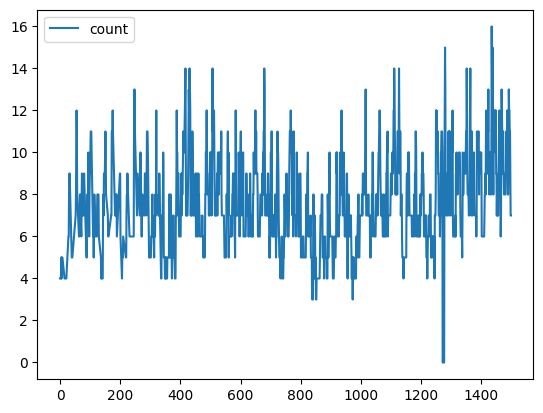

In [18]:
##FOR
df_form = ml_data_form.reset_index(drop=True).copy()
#60T
df_60T_form = pd.concat([df_form.iloc[0:1500]])

with open('df_60T_form.pkl', 'wb') as f:
    df_60T_form.to_pickle(f)

#d
df_form = df_60T_form.reset_index(drop=True).copy()
# drop rows where last_3_week_skew is nan
df_form = df_form.dropna(subset=['last_3_week_skew'])
# reduce distance greater than 50
df_form['distance_from_home'] = df_form['distance_from_home'].apply(lambda x: x if x < 50 else 50)
# df_form['distance_from_home_2'] = df_form['distance_from_home_2'].apply(lambda x: x if x < 50 else 50)
df_train_form = df_form.loc[:int(df_form.shape[0]*0.8),:]
df_test_form = df_form.loc[int(df_form.shape[0]*0.8):,:]

# ## ZUKA

df_zuka = ml_data_zuka.reset_index(drop=True).copy()
df_form.plot(y='count')

#60T
df_60T_zuka = pd.concat([df_zuka.iloc[900:1400], df_zuka.iloc[1900:]])
with open('df_60T_zuka.pkl', 'wb') as f:
    df_60T_zuka.to_pickle(f)

df_zuka = df_60T_zuka.reset_index(drop=True).copy()
# df_zuka['distance_from_home_2'] = df_zuka['distance_from_home_2'].apply(lambda x: x if x < 30 else 30)
df_zuka['distance_from_home'] = df_zuka['distance_from_home'].apply(lambda x: x if x < 30 else 30)
df_train_zuka = df_zuka.loc[:int(df_zuka.shape[0]*0.8),:]
df_test_zuka = df_zuka.loc[int(df_zuka.shape[0]*0.8):,:]


# df = df_60T.reset_index(drop=True).dropna()

df_train = pd.concat([df_train_form, df_train_zuka]).reset_index(drop=True).dropna()
df_test = pd.concat([df_test_form, df_test_zuka]).reset_index(drop=True).dropna()




<AxesSubplot:>

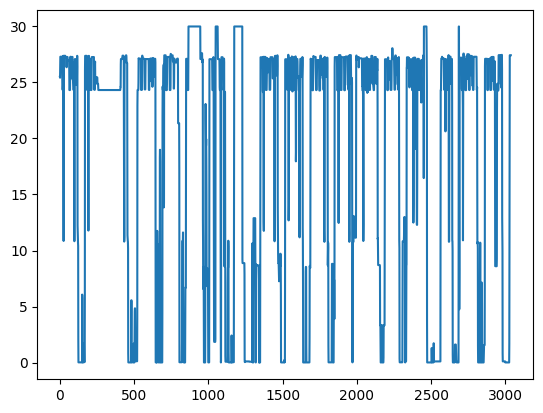

In [19]:
#plot df_form longtime_mean
df_zuka['distance_from_home'].plot()

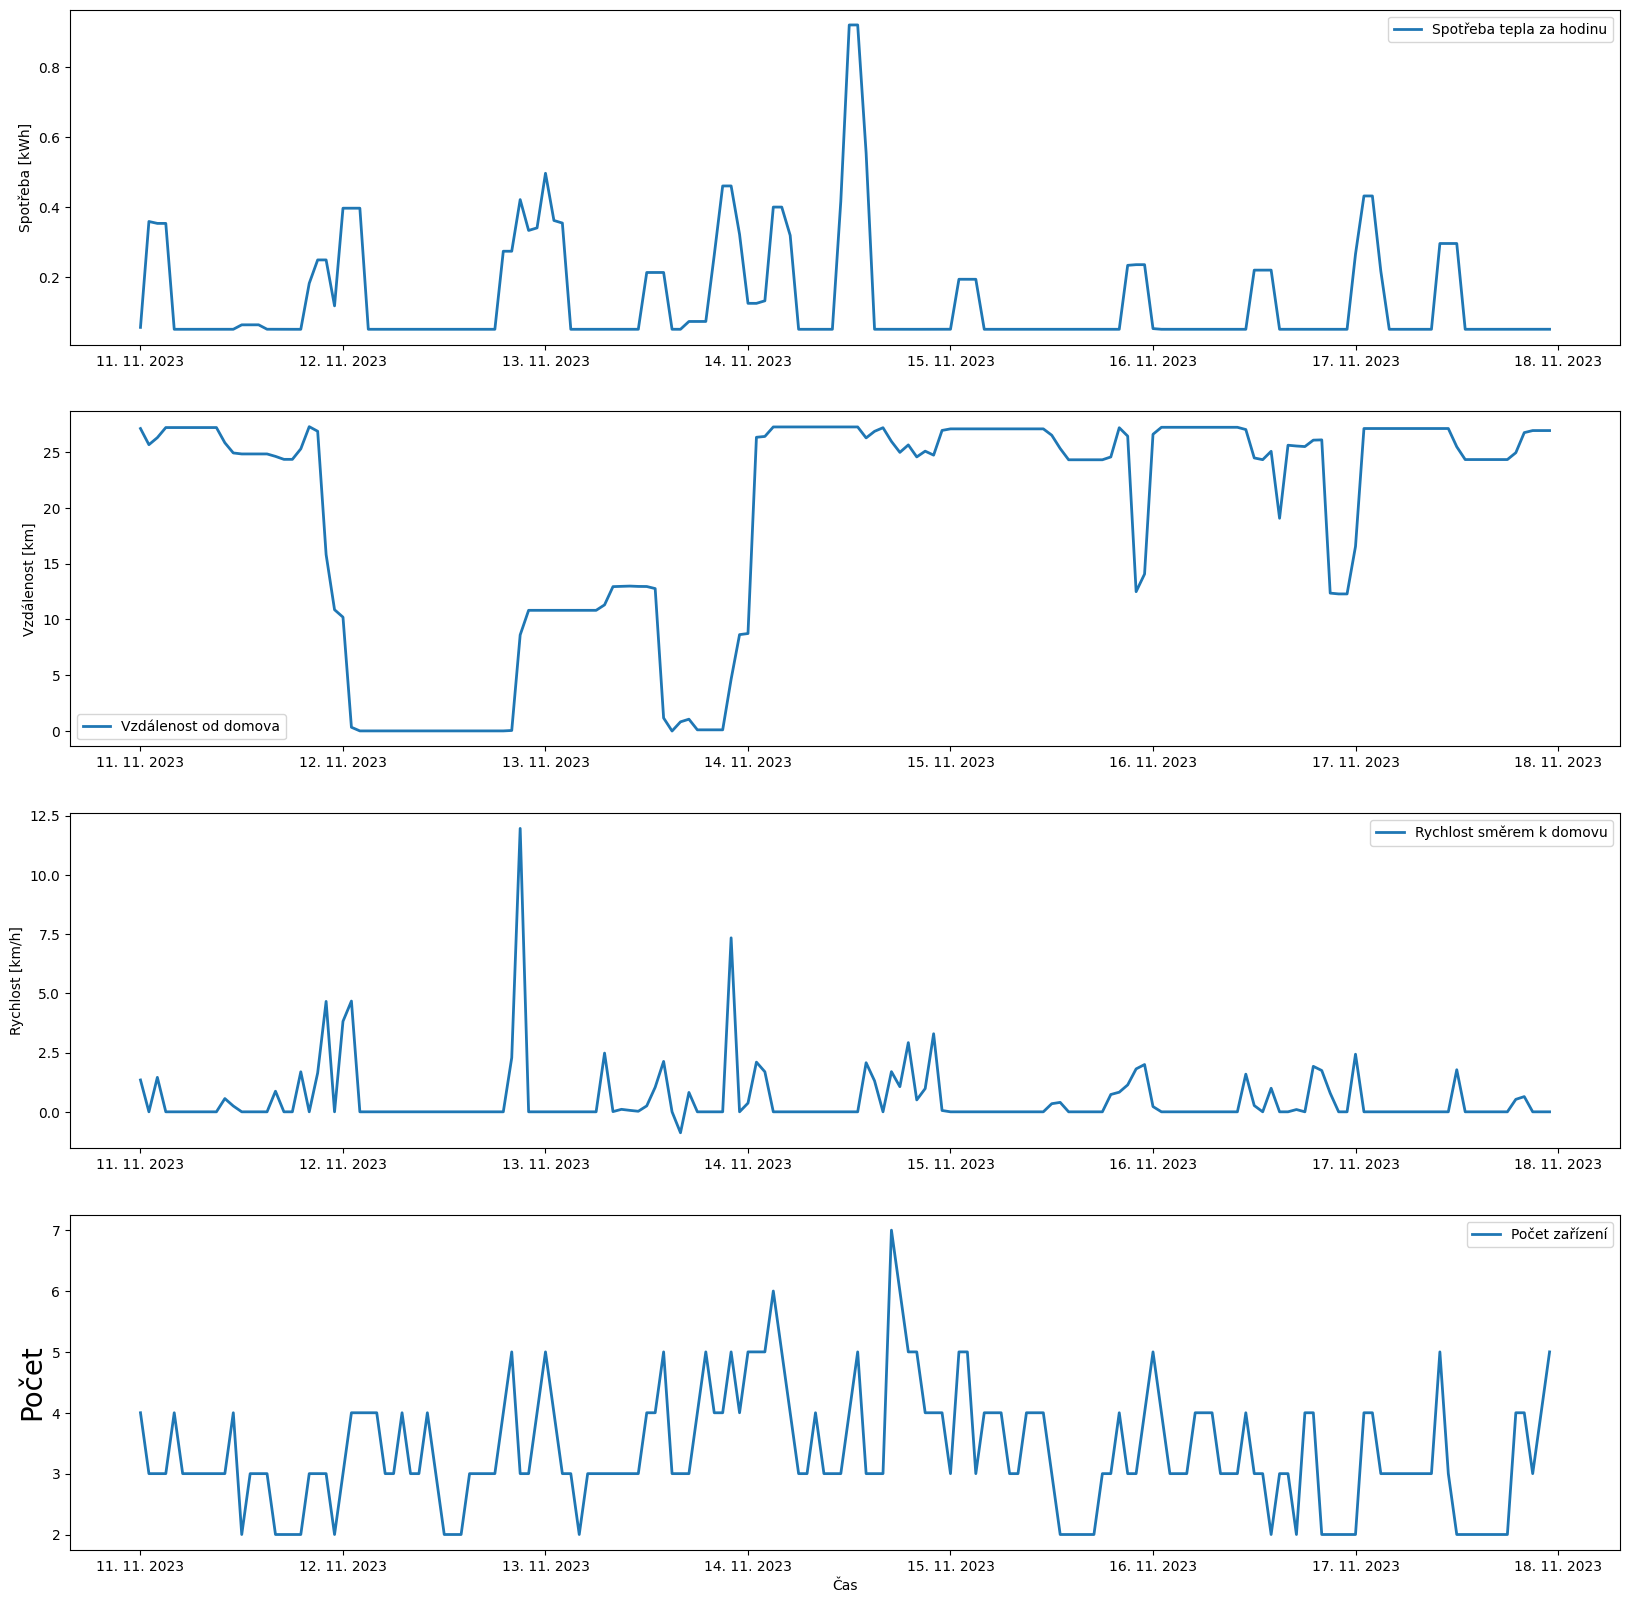

In [20]:
df_plot = df_train.copy()
df_plot = df_plot[-168:]
# create a plots with longitme mean, distance_from_home, speed_towards_home and count
# import mdates
import matplotlib.dates as mdates
fig, axs = plt.subplots(4, 1, figsize=(20, 20))
# create an index as a time with start 11.11.2023, duration one week by 1h
df_plot['time'] = pd.date_range(start='11/11/2023', periods=len(df_plot), freq='H')

# show x labels as DD. MM. YYYY
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d. %m. %Y'))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d. %m. %Y'))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%d. %m. %Y'))
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%d. %m. %Y'))
df_plot = df_plot.set_index('time')

axs[0].plot(df_plot['longtime_mean'], label='longtime_mean', linewidth=2)
# axs[0].set_title('Spotřeba tepla za hodinu')
#set y axis label
axs[0].set_ylabel('Spotřeba [kWh]')
axs[0].legend(['Spotřeba tepla za hodinu'])

axs[1].plot(df_plot['distance_from_home'], label='distance_from_home', linewidth=2)
# axs[1].set_title('Vzdálenost od domova')
axs[1].set_ylabel('Vzdálenost [km]')
axs[1].legend(['Vzdálenost od domova'])

axs[2].plot(df_plot['speed_towards_home'], label='speed_towards_home', linewidth=2)
# axs[2].set_title('Rychlost směrem k domovu')
axs[2].set_ylabel('Rychlost [km/h]')
axs[2].legend(['Rychlost směrem k domovu'])

axs[3].plot(df_plot['count'], label='count', linewidth=2)
# axs[3].set_title('Počet zařízení připojených k Wi-Fi')
#set label
axs[3].set_ylabel('Počet', fontsize=20)
axs[3].legend(['Počet zařízení'])

# set x axis label for all plots
axs[3].set_xlabel('Čas')
# increase a font
plt.rcParams.update({'font.size': 20})

# save plot with dpi 300
plt.savefig('features_plot.pdf', dpi=300)



## Normalize the Data
- for available scalers see: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
- becareful of outliers when scaling!
- perform the normalization on the pandas dataframe

## Use a data generator
- creates batches on the fly
- good for data with large number of rows and features
- don't need to perform lags on dataframe
- the function below was adapted from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
- note: Keras added a TimeseriesGenerator class in version 2.1.5 
    - https://github.com/keras-team/keras/releases/tag/2.1.5
    - keras.preprocessing.sequence.TimeseriesGenerator
keras.preprocessing.sequence.TimeseriesGenerator
It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `dataframe`: pandas dataframe with feature matrix and target column
* `target_name`: string of column with target values
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

## create train, validation, test data generators
- we will 20% of the df_train to get the validation generator
    - use the min_index,max_index arguments for slices from generator function

In [21]:
from pytz import utc
import pandas as pd
import numpy as np
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta



Importing /Users/adamgrunwald/Desktop/FIT/smart_boiler/smartboiler/src/smartboiler/forecast.py
Importing /Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/smartboiler/__init__.py
Importing /Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/smartboiler/data_handler.py


In [22]:
# get nan values in df_train_form
nan_values = df_train_form.isnull().sum()
print(nan_values)

longtime_mean          0
last_3_week_skew       0
last_3_week_std        0
distance_from_home     0
speed_towards_home     0
count                  0
heading_to_home_sin    0
heading_to_home_cos    0
temperature            0
humidity               0
wind_speed             0
weekday_sin            0
weekday_cos            0
hour_sin               0
hour_cos               0
dtype: int64


In [23]:
df_train

,longtime_mean,last_3_week_skew,last_3_week_std,distance_from_home,speed_towards_home,count,heading_to_home_sin,heading_to_home_cos,temperature,humidity,wind_speed,weekday_sin,weekday_cos,hour_sin,hour_cos
0,0.054398,1.602736,0.017909,9.212303,0.000000,4.0,-0.218958,0.975734,13.0,81.0,23.5,0.781831,0.623490,1.224647e-16,-1.000000
1,0.064651,1.728807,0.018877,9.216247,0.011106,4.0,-0.218988,0.975728,11.5,91.0,22.0,0.781831,0.623490,-2.588190e-01,-0.965926
2,0.063365,-0.927480,0.024722,10.215066,4.493765,4.0,-0.175419,0.983126,10.5,86.0,20.5,0.781831,0.623490,-5.000000e-01,-0.866025
3,0.079811,1.715907,0.027351,9.081651,12.227194,4.0,-0.135172,0.970429,10.5,86.0,17.1,0.781831,0.623490,-7.071068e-01,-0.707107
4,0.069874,1.632077,0.025120,0.581658,0.176994,5.0,-0.492505,-0.425377,10.5,86.0,17.1,0.781831,0.623490,-8.660254e-01,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352,0.052095,1.731565,0.000000,24.940384,0.526268,4.0,-0.924463,0.381014,11.6,58.0,44.2,0.974928,-0.222521,-2.588190e-01,-0.965926
3353,0.052095,1.730403,0.002105,26.738939,0.641672,4.0,-0.943207,0.331155,12.4,55.0,43.8,0.974928,-0.222521,-5.000000e-01,-0.866025
3354,0.052180,1.562178,0.000390,26.923738,0.000000,3.0,-0.946915,0.321483,11.5,61.0,40.8,0.974928,-0.222521,-7.071068e-01,-0.707107
3355,0.052169,1.295224,0.000133,26.923738,0.000000,4.0,-0.946915,0.321483,11.5,61.0,40.8,0.974928,-0.222521,-8.660254e-01,-0.500000


In [24]:
def get_model(
    df_train,
    df_focused_train,
    dataHandler,
    predicted_columns,
    model_path,
    scaler_path,
    train_on_all,
    do_train,
):

    # use previous 450 samples to predict next target ('pollution') samples

    start_of_data = datetime(2023, 10, 1, 0, 0, 0)
    end_of_training_data = datetime(2024, 3, 16, 0, 0, 0)
    forecast = Forecast(
        dataHandler,
        start_of_data=start_of_data,
        model_path=model_path,
        scaler_path=scaler_path,
        predicted_columns=predicted_columns,
    )
    forecast.build_model()

    if do_train:
        if train_on_all:
            forecast.train_model(df_training_data=df_train)
        forecast.train_model(df_training_data=df_form)

    forecast.load_model(

    )
    return forecast


predicted_columns = [
        "longtime_mean",
]
model_path_form = "model_form.weights.h5"
scaler_path_form = "scaler_form.pkl"

model_path_zuka = "model_zuka.weights.h5"
scaler_path_zuka = "scaler_zuka.pkl"


forecast = get_model(
    df_train,
    df_form,
    dataHandlerForm,
    predicted_columns,
    model_path_form,
    scaler_path_form,
    train_on_all = True,
    do_train=True,
)


df_test_norm = df_train_form.reset_index(drop=True).copy()
df_test_direct = df_test_form


forecast = get_model(
    df_train,
    df_train_zuka,
    dataHandlerZuka,
    predicted_columns,
    model_path_zuka,
    scaler_path_zuka,
    train_on_all = True,
    do_train=True,
)
df_test_norm = df_train_zuka.reset_index(drop=True).copy()
df_test_direct = df_test_zuka


2024-04-30 21:43:08.235242: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-30 21:43:08.235269: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-30 21:43:08.235279: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-30 21:43:08.235316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-30 21:43:08.235335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-04-30 21:43:09.116710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.98914, saving model to model_form.weights.h5
186/186 - 4s - loss: 1.2001 - val_loss: 0.9891 - 4s/epoch - 20ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.98914 to 0.94925, saving model to model_form.weights.h5
186/186 - 2s - loss: 1.0252 - val_loss: 0.9492 - 2s/epoch - 12ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.94925 to 0.94357, saving model to model_form.weights.h5
186/186 - 2s - loss: 0.8183 - val_loss: 0.9436 - 2s/epoch - 12ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.94357
186/186 - 2s - loss: 0.8436 - val_loss: 1.0277 - 2s/epoch - 13ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.94357
186/186 - 2s - loss: 0.8353 - val_loss: 0.9443 - 2s/epoch - 12ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.94357
186/186 - 2s - loss: 0.6786 - val_loss: 0.9933 - 2s/epoch - 12ms/step
Epoch 7/100

Epoch 7: val_loss did not improve from 0.94357
186/186 - 2s - loss: 0.7048 - val_loss: 0.9744 

In [25]:

# df_test_norm = df_test_zuka.copy()
df_test_norm[df_test_norm.columns] = forecast.scaler.transform(df_test_norm)



df_test_norm = df_test_norm[-forecast.lookback*4:]
test_gen = forecast.mul_generator(
    dataframe=df_test_norm,
    target_names=forecast.predicted_columns,
    lookback=forecast.lookback,
    delay=forecast.delay,
    min_index=0,
    max_index=None,
    step=1,
    shuffle=False,
    batch_size=forecast.batch_size,
)

last_batch = next(test_gen)

# Step 3: Extract the last batch of features (X_batch) and target values (y_truth_batch)
(X_batch, y_truth) = last_batch

In [26]:
X_df = pd.DataFrame(X_batch[0])
X = pd.DataFrame(X_df.values.flatten()).T


In [27]:
import matplotlib.pyplot as plt
import plotly.express as px


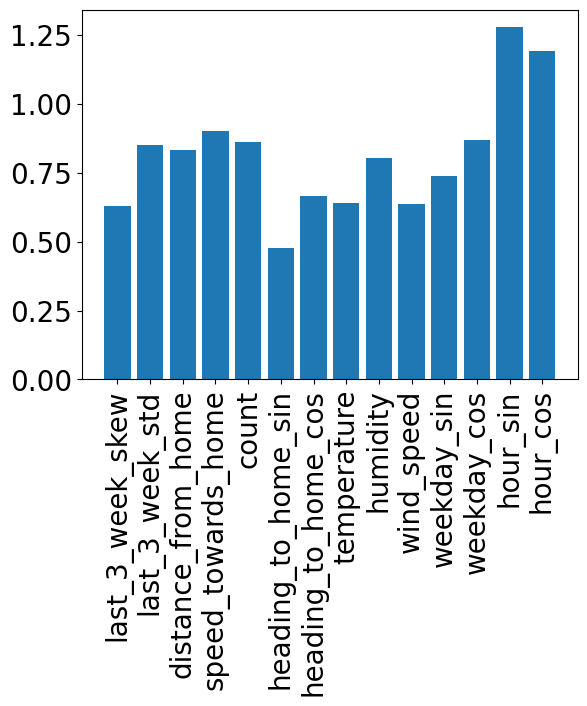

In [28]:
feature_df = pd.DataFrame(columns=['feature','layer','neuron','weight','abs_weight'])
features = ["last_3_week_skew","last_3_week_std","distance_from_home","speed_towards_home","count","heading_to_home_sin","heading_to_home_cos","temperature","humidity","wind_speed","weekday_sin","weekday_cos","hour_sin","hour_cos",]

for i,layer in enumerate(forecast.model.layers[:-1]): 
    w = layer.get_weights()
    w = np.array(w[0])
    n = 0
    for neuron in w.T:
        for f,name in zip(neuron,X.columns):
            feature_df.loc[len(feature_df)] = [name,i,n,f,abs(f)]
        
        n+=1
        
feature_df = feature_df.sort_values(by=['abs_weight'])
feature_df.reset_index(inplace=True)
feature_df = feature_df.drop(['index'], axis=1)

plt.bar(feature_df['feature'],feature_df['abs_weight'])
plt.xticks(ticks=range(len(features)), labels=features, rotation=90)

plt.show()

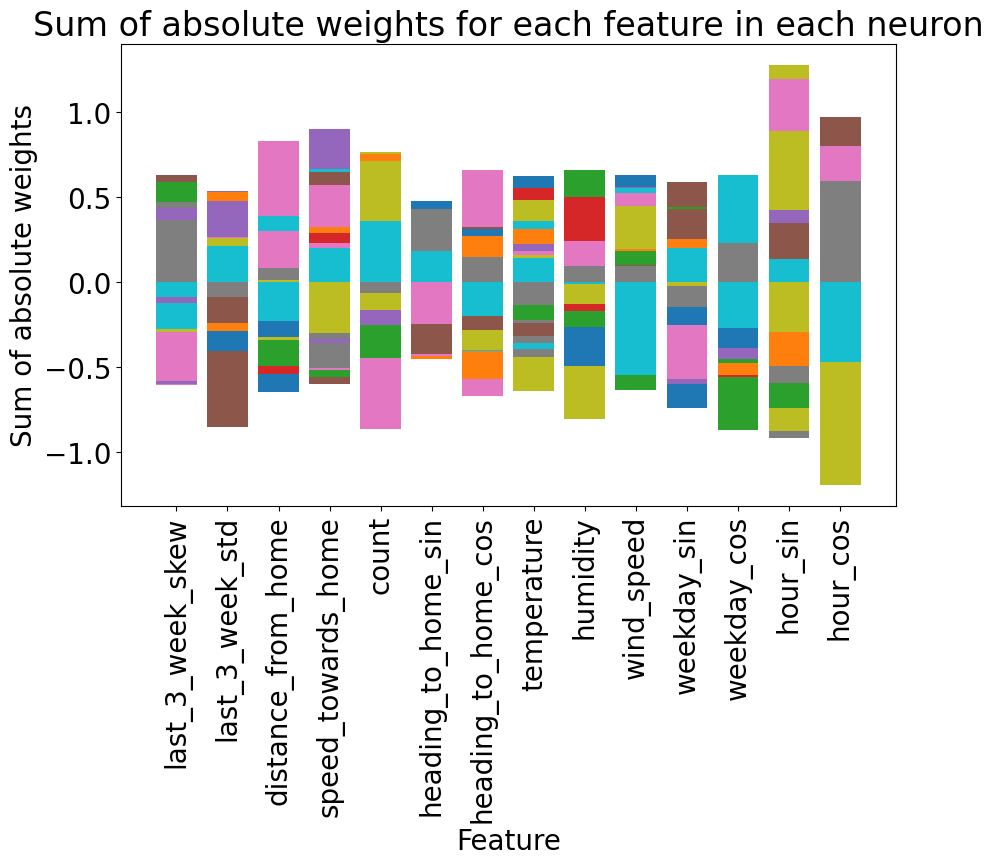

In [29]:
grouped_df = feature_df.groupby(['feature', 'neuron'])['weight'].sum().reset_index()
# Plotting the bar chart
plt.figure(figsize=(10, 6))
for neuron in grouped_df['neuron'].unique():
    feature_data = grouped_df[grouped_df['neuron'] == neuron]
    plt.bar(feature_data['feature'], feature_data['weight'], label=neuron) 
plt.xticks(ticks=range(len(features)), labels=features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Sum of absolute weights')
plt.title('Sum of absolute weights for each feature in each neuron')
plt.show()

In [30]:

left_test = datetime(2023,12,30)
right_test = datetime(2024,4,1)

from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

# df_test_direct, _ = forecast.dataHandler.get_data_for_prediction(left_test, right_test)

df_test_norm = df_test_direct.reset_index(drop=True).copy()

# df_test_norm = df_test_zuka.copy()
df_test_norm[df_test_norm.columns] = forecast.scaler.transform(df_test_norm)


In [31]:
test_gen = forecast.mul_generator(dataframe = df_test_norm, 
                     target_names = predicted_columns, 
                     lookback = forecast.lookback,
                     delay = forecast.delay,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = df_test_norm.shape[0])
(X, y_truth) = next(test_gen)
# X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

y_pred = forecast.model.predict(X)

18/18 [==============================] - 0s 5ms/step


In [32]:
num_targets = len(predicted_columns)
len_columns = len(df_test_norm.columns)
num_features = len_columns - num_targets


# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate(
    (y_pred, np.zeros((y_pred.shape[0], num_features))), axis=1
)

y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)

y_truth_concat = np.concatenate(
    (y_truth, np.zeros((y_truth.shape[0], num_features))), axis=1
)
y_truth_concat = forecast.scaler.inverse_transform(y_truth_concat)

# create a dataframe from y_pred_inv and y_truth_concat
y_pred_inv_df = pd.DataFrame(y_pred_inv, columns=df_test.columns)
y_truth_concat_df = pd.DataFrame(y_truth_concat, columns=df_test.columns)

y_pred_inv_df['truth'] = y_truth_concat_df['longtime_mean']
y_pred_inv_df['longtime_mean'] = y_pred_inv_df['longtime_mean'].clip(lower=0.05)

y_pred_inv_df = y_pred_inv_df.dropna()  

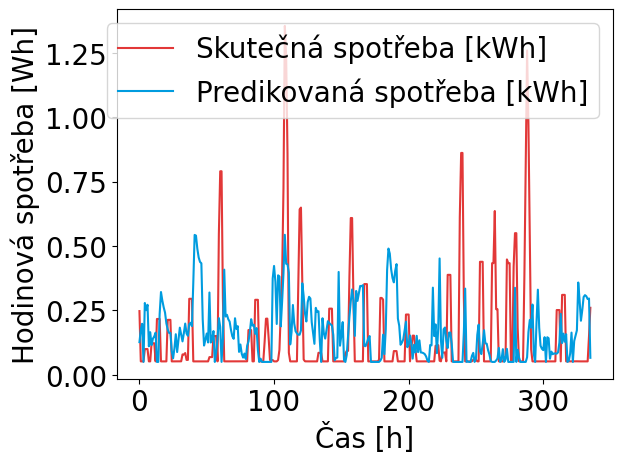

R2 =  0.020995208832281564
mse =  0.04594841436936426
rmse =  0.21435581253925506
integral delta =  -5.602400342900811
integral_truth =  94.67920927069537
integral_pred =  100.2816096135962
integral delta percentual =  0.05917244541917439
mape: 154.33349343358756


In [33]:





for i in range(num_targets):
    
    datetime_start = datetime(2024, 3, 14, 0, 0, 0)
    datetime_end = datetime_start + timedelta(hours=167)
    datetime_range = pd.date_range(datetime_start, datetime_end, freq='H')
    j = 100
    plt.figure()
    y_plot = y_pred_inv_df.copy()
    y_plot = y_plot[j:j+2*168].reset_index(drop=True)
    # y_plot = y_plot[:].reset_index(drop=True)
    y_evaluate = y_plot.copy()
    weeks_range = range(0, len(y_plot.index), 1)
    plt.plot(weeks_range,y_plot['truth'], label=f'Skutečná spotřeba [kWh]', alpha=1,color='#e23838' )
    plt.plot(weeks_range,y_plot['longtime_mean'], label=f'Predikovaná spotřeba [kWh]', alpha=1, color='#009cdf')
    # set axis labels
    mape = np.mean(np.abs((y_pred_inv_df['truth'] - y_pred_inv_df['longtime_mean']) / y_pred_inv_df['truth'])) * 100
    
    # plt.title(f'Prediction and real consumption of heat from boiler')
    # plt.title(f'Predikovaná a skutečná hodinová spotřeba tepla z bojleru')
    plt.xlabel('Time [h]')
    plt.xlabel('Čas [h]')
    plt.xticks(rotation=0)
    plt.ylabel('Hourly comsumption [Wh]')
    plt.ylabel('Hodinová spotřeba [Wh]')
    plt.legend()
    plt.savefig(f'prediction_form.pdf', format='pdf', dpi=500)

    plt.show()
    
    # save fig as vector png
    
    # save as pdf
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_inv_df['longtime_mean'],y=y_pred_inv_df['truth'])
    r2 = np.corrcoef(y_pred_inv_df['truth'], y_pred_inv_df['longtime_mean'])[0, 1] ** 2
    mse = mean_squared_error(y_true=y_pred_inv_df['truth'], y_pred=y_pred_inv_df['longtime_mean'], squared=True)
    rmse = mean_squared_error(y_true=y_pred_inv_df['truth'], y_pred=y_pred_inv_df['longtime_mean'], squared=False)


    print('R2 = ',r2)
    print('mse = ',mse)
    print('rmse = ',rmse)
    #print integral of y_pred_curr - y_truth_curr
    print('integral delta = ',np.trapz(y_pred_inv_df['truth'] - y_pred_inv_df['longtime_mean']))
    print('integral_truth = ',np.trapz(y_pred_inv_df['truth']))
    print('integral_pred = ',np.trapz(y_pred_inv_df['longtime_mean']))
    
    # print percentual differece between integral of y_pred_curr - y_truth_curr and integral_truth
    print('integral delta percentual = ',np.trapz(y_pred_inv_df['longtime_mean'] - y_pred_inv_df['truth'])/np.trapz(y_pred_inv_df['truth']))
    print('mape:', mape)
    







In [34]:
def custom_evaluation(df):
    # Count the number of instances where actual is non-zero
    non_zero_count = df[df['truth'] > 0.1].shape[0]
    
    # Calculate absolute error for each prediction
    absolute_errors = np.abs(df['truth'] - df['longtime_mean'])
    
    # Calculate the mean absolute error for non-zero instances
    if non_zero_count > 0:
        mean_absolute_error_non_zero = np.sum(absolute_errors[df['truth'] > 0.1]) / non_zero_count
    else:
        mean_absolute_error_non_zero = 0  # Handle case where there are no non-zero instances
    
    # Calculate the overall mean absolute error
    mean_absolute_error = np.mean(absolute_errors)
    
    # Weighted mean absolute error to give more importance to non-zero instances
    custom_metric = 0.8 * mean_absolute_error + 0.2 * mean_absolute_error_non_zero
    
    return custom_metric

custom_evaluation_result = custom_evaluation(y_evaluate)
print(custom_evaluation_result)

0.17147687174333046


In [35]:

from pytz import utc
import pandas as pd
import numpy as np
from data_handler import DataHandler
from forecast import Forecast
from datetime import datetime, timedelta
start_of_data = datetime(2023, 11, 1)
end_of_data = datetime(2023, 12, 10)
end_of_training_data = datetime(2023, 12, 31, 0, 0, 0)
dataHandler = DataHandler(
    "localhost",
    "smart_home_zukalovi",
    "root",
    "root",
    "shelly1pm_84cca8b07eae",
    "shelly1pm_84cca8b07eae_power",
    "esphome_web_c771e8_tmp3",
    "esphome_web_c771e8_ntc_temperature_b_constant",
    "esphome_web_c771e8_ntc_temperature_b_constant_2",
    device_tracker_entity_id="klara_z_iphone",
    device_tracker_entity_id_2="klara_z_iphone",
    home_longitude=49.412897925874184,
home_latitude=16.514843458109933,
start_of_data=start_of_data,
)



## Create LSTM model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU
- can also use lightwieght GRU layers

## Fit the Model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU

## Get model predictions on df_test
- get (X,y_truth) by calling train_gen using next
- set the batch_size

In [36]:
model = load_model('lstm_model_mul_var.keras', custom_objects={'r2_keras': r2_keras})

NameError: name 'r2_keras' is not defined

In [ ]:
df_test_norm.shape

In [ ]:
# append a value to all rows in longtimemean column zeroes

test_gen = forecast.mul_generator(dataframe = df_test_norm, 
                      target_names = predicted_columns, 
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = df_test.shape[0])
(X, y_truth) = next(test_gen)
y_pred = model.predict(X)

num_targets = len(predicted_columns)
len_columns = len(df_test.columns)
num_features = len_columns - num_targets

# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate(
    (y_pred, np.zeros((y_pred.shape[0], num_features))), axis=1
)
y_pred_inv = scaler.inverse_transform(y_pred_inv)

y_truth = np.concatenate(
    (y_truth, np.zeros((y_truth.shape[0], num_features))), axis=1
)
y_truth = scaler.inverse_transform(y_truth)


In [ ]:
y_pred_abs = np.abs(y_pred_inv) - 0.2
for i in range(num_targets):
    plt.figure()
    plt.plot(y_truth[:, i], label=f'True {predicted_columns[i]}')
    plt.plot(y_pred_abs[:, i], label=f'Predicted {predicted_columns[i]}')
    plt.legend()
    plt.show()
    y_pred_curr = y_pred_abs[:48, i]
    y_truth_curr = y_truth[:48, i]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_curr,y=y_truth_curr)
    mse = mean_squared_error(y_true=y_truth_curr, y_pred=y_pred_curr, squared=True)
    rmse = mean_squared_error(y_true=y_truth_curr, y_pred=y_pred_curr, squared=False)


    print('R2 = ',r_value*r_value)
    print('mse = ',mse)
    print('rmse = ',rmse)
    #print integral of y_pred_curr - y_truth_curr
    print('integral = ',np.trapz(y_pred_curr - y_truth_curr))
    

In [ ]:
from datetime import timedelta, datetime
import pandas as pd


In [ ]:
def add_empty_row(df, date_time):
    new_row_df = pd.DataFrame(
        columns=df.columns,
        data=[
            [
                0,
                0,
                0,
                0,
                0,
                0,
                np.sin(2 * np.pi * date_time.weekday() / 7),
                np.cos(2 * np.pi * date_time.weekday() / 7),
                np.sin(2 * np.pi * date_time.hour / 24),
                np.cos(2 * np.pi * date_time.hour / 24),
                np.sin(2 * np.pi * date_time.minute / 60),
                np.cos(2 * np.pi * date_time.minute / 60),
            ]
        ],
    )
    df = pd.concat([df, new_row_df], ignore_index=True)
    df = df.reset_index(drop=True)
    
    return df

def get_forecast_next_steps(left_time_interval, right_time_interval):
    # Define the indices for the different predictions and truths

    num_targets = len(predicted_columns)
    len_columns = len(df_test.columns)


    forecast_future = pd.DataFrame()

    df_all = dataHandler.get_data_for_prediction(
        left_time_interval=left_time_interval,
        right_time_interval=right_time_interval,
        predicted_columns=predicted_columns,
    )
    df_all = df_all.dropna()
    df_all = df_all.reset_index(drop=True)
    forecast_future = pd.DataFrame()

    current_forecast_begin_date = right_time_interval + timedelta(hours=0.5)
    
    df_all = add_empty_row(df_all, current_forecast_begin_date)
    
    current_forecast_begin_date += timedelta(hours=0.5)

    # prediction for next 6 hours
    for i in range(0, 12):
        df_all = add_empty_row(df_all, current_forecast_begin_date)
        current_forecast_begin_date += timedelta(hours=0.5)

        df_predict_norm = df_all.copy()

        df_predict_norm[df_all.columns] = scaler.transform(df_all)
        # create predict df with values
        predict_gen = mul_generator(
            dataframe=df_predict_norm,
            target_names=predicted_columns,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=None,
            step=1,
            shuffle=False,
            batch_size=df_predict_norm.shape[0],
        )

        (X, y_truth) = next(predict_gen)

        y_pred = model.predict(X, verbose=0)
        # np.expand_dims(y_truth,axis=1).shape
        y_pred_inv = np.concatenate(
            (y_pred, np.zeros((y_pred.shape[0], len_columns-num_targets))), axis=1
        )
        y_pred_inv = scaler.inverse_transform(y_pred_inv)
        # get last predicted value
        y_pred_inv = y_pred_inv[-1, :]

        # append y_pred_inv to df_all
        df_all.iloc[-2,:num_targets] = y_pred_inv[:num_targets]
        # drop first row
        df_all = df_all[1:]

        forecast_future = pd.concat(
            [
                forecast_future,
                df_all.iloc[-2][:num_targets],
            ],
            axis=0,
        )
        forecast_future = forecast_future.reset_index(drop=True)
        

    return forecast_future, df_all

# last 48 values

In [ ]:

one_week_prediction = []
number_of_30_minutes = 14*24*2
end_train = datetime(2023,12,29, 0, 0, 0)
start_of_data_loader_for_forecast = end_train
end_of_data_loader_for_forecast = end_train + timedelta(hours=48)


for i in range(0, number_of_30_minutes):
    next_steps, _ = get_forecast_next_steps(left_time_interval=start_of_data_loader_for_forecast, right_time_interval=end_of_data_loader_for_forecast)
    one_week_prediction.append(next_steps)
    start_of_data_loader_for_forecast += timedelta(minutes=30)
    end_of_data_loader_for_forecast += timedelta(minutes=30)

In [ ]:
df_truth = dataHandler.get_data_for_prediction(left_time_interval=end_train+timedelta(hours=48), right_time_interval=end_train+timedelta(hours=48)+timedelta(minutes=30*number_of_30_minutes))

In [ ]:
list_df = []
for df in one_week_prediction:
    df_reshaped = (pd.DataFrame(np.reshape(df.values, (-1, 6)))).T
    df_reshaped['prediction'] = [i for i in predicted_columns]

    # transpose 
    list_df.append(df_reshaped)
merged_df = pd.concat(list_df, ignore_index=True)
merged_df['DataFrame_Order'] = [i for i in range(len(list_df)) for _ in range(6)]

    


In [ ]:
longtime_mean = merged_df[merged_df['prediction'] == 'longtime_mean']
distance_from_home = merged_df[merged_df['prediction'] == 'distance_from_home']
speed_towards_home = merged_df[merged_df['prediction'] == 'speed_towards_home']
count = merged_df[merged_df['prediction'] == 'count']
heading_to_home_sin = merged_df[merged_df['prediction'] == 'heading_to_home_sin']
heading_to_home_cos = merged_df[merged_df['prediction'] == 'heading_to_home_cos']




In [ ]:
merged_df

In [ ]:
# shift the columns by -i
shifted_df = merged_df.copy()
for j in predicted_columns:
    for i in range(0,12):
        shifted_df.loc[shifted_df['prediction'] == j, i] = shifted_df.loc[shifted_df['prediction'] == j, i].shift(-i)
        


In [ ]:
#keep only columns from predicted columns
data_truth = df_truth[predicted_columns]

In [ ]:
result_df = shifted_df.copy()
result_df['truth'] = 0  
for prediction_column in predicted_columns:

    for i in range(0,672):
        result_df.loc[(result_df['prediction'] == prediction_column) & (result_df['DataFrame_Order'] == i), 'truth' ] = data_truth.loc[i, prediction_column]

In [ ]:
result_df = result_df.dropna()

In [ ]:
for predicted_column in predicted_columns:
    number_of_steps = 1
    #create a list of collors from 0 to 12 based on color
    colors = plt.cm.viridis(np.linspace(0, 1, number_of_steps))
    for i in range(0, number_of_steps):
        plt.plot(result_df.loc[result_df['prediction']==predicted_column,i][:], label=f'predicted_{predicted_column}_{i}', color=colors[i], alpha=0.2)
    # i =0
    # plt.plot(df_shift[i], label=f'{i}_step_ahead')
    plt.plot(result_df.loc[result_df['prediction'] == predicted_column,'truth'][:], label='truth')
    plt.legend()   
    plt.show()

### Need to remove normalization
- since we preformed normlization transform on 7 cols of dataframe, we need to add dummy colums to preds

### Get R2 for this prediction

In [ ]:
print(y_truth.shape)

In [ ]:
print(y_pred.shape)

In [ ]:
#plot y_truth and y_pred
plt.plot(y_truth[0], color = 'red', label = 'Real data')

plt.plot(y_pred)


In [ ]:

plt.plot(y_truth, color = 'red', linestyle='dotted')
plt.plot(y_pred, color = 'blue', linestyle='dotted')
# change x ticks to dates
print(np.arange(0, df_test.shape[0], step=24))
# create list of dates by 1 hour from 2023-11-01 00:00:00 to 2023-11-30 23:00:00
start = pd.to_datetime('2023-12-16 19:00:00')
end = start + pd.Timedelta(hours=df_test.shape[0])
dates = pd.date_range(start, end, freq='1H')

# transform dates to format MM-DD HH
dates = dates.strftime('%Y-%m-%d')
# set xticks to dates
plt.xticks(np.arange(0, df_test.shape[0], step=24), dates[np.arange(0, df_test.shape[0], step=24)], rotation=45)

#add legend
plt.legend(['skutečnost','predikce'])

# add x and y label
plt.xlabel('Datum')
plt.ylabel('Spotřeba tepla [kJ]')


plt.show()

## Let's try the evaluate_generator in keras

In [ ]:
(_,r2) = model.evaluate_generator(generator=test_gen,steps=1,workers=1)
print('R2 = ',r2)
